# **Survival Analysis for Colorectal Cancer Patients**

## **Imports**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA

import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import (
    cross_val_predict,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
import lifelines

## **EDA**

In [2]:
patient_data = pd.read_csv("data/Colorectal Cancer Patient Data.csv")
gene_expression_data = pd.read_csv("data/Colorectal Cancer Gene Expression Data.csv")
display(patient_data.info())
display(gene_expression_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       63 non-null     int64  
 1   ID_REF           62 non-null     object 
 2   Age (in years)   62 non-null     float64
 3   Dukes Stage      62 non-null     object 
 4   Gender           62 non-null     object 
 5   Location         62 non-null     object 
 6   DFS (in months)  62 non-null     float64
 7   DFS event        62 non-null     float64
 8   Adj_Radio        62 non-null     float64
 9   Adj_Chem         62 non-null     float64
dtypes: float64(5), int64(1), object(4)
memory usage: 5.1+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1935 entries, 0 to 1934
Data columns (total 64 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1935 non-null   int64  
 1   ID_REF      1935 non-null   object 
 2   GSM877126   1935 non-null   float64
 3   GSM877127   1935 non-null   float64
 4   GSM877128   1935 non-null   float64
 5   GSM877129   1935 non-null   float64
 6   GSM877130   1935 non-null   float64
 7   GSM877131   1935 non-null   float64
 8   GSM877132   1935 non-null   float64
 9   GSM877133   1935 non-null   float64
 10  GSM877134   1935 non-null   float64
 11  GSM877135   1935 non-null   float64
 12  GSM877136   1935 non-null   float64
 13  GSM877137   1935 non-null   float64
 14  GSM877138   1935 non-null   float64
 15  GSM877139   1935 non-null   float64
 16  GSM877140   1935 non-null   float64
 17  GSM877141   1935 non-null   float64
 18  GSM877142   1935 non-null   float64
 19  GSM877143   1935 non-null  

None

In [3]:
# Catch ID_REF from patient_data
patient_ids = list(patient_data['ID_REF'].dropna())

# Select relative columns from gene_expression_data
filtered_gene_expression = gene_expression_data[['ID_REF'] + patient_ids]

In [4]:
# Transposed gene_expression_data
transposed_gene_expression = filtered_gene_expression.set_index('ID_REF').T

# Use PCA to decreasing the dimension
pca = PCA(n_components=10)
gene_data_pca = pca.fit_transform(transposed_gene_expression)
gene_data_pca_df = pd.DataFrame(
    gene_data_pca, 
    index=transposed_gene_expression.index,
    columns=[f'PC{i+1}' for i in range(gene_data_pca.shape[1])]
)
gene_data_pca_df.index.name = 'ID_REF'

In [5]:
# Merge data by ID_REF
cancer_df = pd.merge(patient_data, gene_data_pca_df, on='ID_REF', how='inner')
display(cancer_df.head())

,Unnamed: 0,ID_REF,Age (in years),Dukes Stage,Gender,Location,DFS (in months),DFS event,Adj_Radio,Adj_Chem,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,0,GSM877126,62.0,A,Male,Left,108.0,0.0,1.0,0.0,10.034928,-2.563461,0.553594,3.786064,5.491033,2.113068,0.850123,-1.365781,-1.001487,0.467374
1,1,GSM877127,77.0,B,Male,Left,40.0,1.0,1.0,0.0,3.952900,5.896938,-9.498808,-8.151790,-1.408558,3.904793,2.074637,3.621052,1.138539,4.319512
2,2,GSM877128,66.0,C,Female,Left,49.0,0.0,1.0,0.0,5.775725,-3.307617,-1.514136,1.656845,0.277657,0.466875,-0.887899,2.521145,-6.819103,2.272644
3,3,GSM877129,72.0,D,Female,Left,45.0,0.0,1.0,1.0,12.069910,-3.575149,0.164506,0.873292,-0.304559,-1.279556,-1.271283,4.878356,0.760081,-4.307443
4,4,GSM877130,75.0,C,Male,Left,40.0,0.0,0.0,1.0,0.704046,5.934426,4.480248,-1.633834,2.685619,0.053008,3.949680,2.330419,0.315755,0.129697


In [6]:
# Drop columns: "unnamed: 0", "ID_REF"
cancer_df = cancer_df.drop(columns=["Unnamed: 0", "ID_REF"], errors='ignore')

In [7]:
display(cancer_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age (in years)   62 non-null     float64
 1   Dukes Stage      62 non-null     object 
 2   Gender           62 non-null     object 
 3   Location         62 non-null     object 
 4   DFS (in months)  62 non-null     float64
 5   DFS event        62 non-null     float64
 6   Adj_Radio        62 non-null     float64
 7   Adj_Chem         62 non-null     float64
 8   PC1              62 non-null     float64
 9   PC2              62 non-null     float64
 10  PC3              62 non-null     float64
 11  PC4              62 non-null     float64
 12  PC5              62 non-null     float64
 13  PC6              62 non-null     float64
 14  PC7              62 non-null     float64
 15  PC8              62 non-null     float64
 16  PC9              62 non-null     float64
 17  PC10             6

None

In [8]:
display(cancer_df.describe())

,Age (in years),DFS (in months),DFS event,Adj_Radio,Adj_Chem,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
count,62.000000,62.000000,62.000000,62.000000,62.000000,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01
mean,61.112903,41.774194,0.596774,0.532258,0.483871,-6.088320e-16,5.730183e-16,1.189013e-15,-8.595275e-16,-5.479488e-16,-9.848753e-16,1.969751e-15,5.318326e-16,1.633102e-15,6.589711e-16
std,9.581582,26.288076,0.494550,0.503032,0.503819,5.984986e+00,5.448934e+00,5.289646e+00,3.707437e+00,3.560856e+00,3.043141e+00,2.942446e+00,2.866659e+00,2.747006e+00,2.688011e+00
min,28.000000,4.000000,0.000000,0.000000,0.000000,-8.734801e+00,-1.009633e+01,-1.348958e+01,-8.151790e+00,-7.374372e+00,-6.927775e+00,-9.725663e+00,-8.668528e+00,-6.819103e+00,-6.508976e+00
25%,56.250000,19.500000,0.000000,0.000000,0.000000,-4.910225e+00,-3.489797e+00,-2.602366e+00,-2.750916e+00,-2.110189e+00,-1.456760e+00,-1.386963e+00,-1.694862e+00,-1.549649e+00,-1.149974e+00
50%,62.000000,38.000000,1.000000,1.000000,0.000000,-1.208833e+00,-8.254880e-01,1.111445e-01,-3.605246e-01,-1.906082e-01,5.593847e-02,3.260334e-01,-8.100692e-02,4.634558e-01,2.190788e-01
75%,67.000000,57.500000,1.000000,1.000000,1.000000,4.018212e+00,2.732425e+00,2.627977e+00,2.183317e+00,1.288891e+00,2.091801e+00,1.633154e+00,2.266200e+00,1.697653e+00,1.067278e+00
max,78.000000,108.000000,1.000000,1.000000,1.000000,1.345370e+01,1.610472e+01,1.591209e+01,9.773375e+00,1.891697e+01,7.146467e+00,6.469778e+00,5.776316e+00,4.685594e+00,8.002474e+00


- **Age Distribution**:
   - Patients are mostly older (median: 62 years), with a moderately small spread.

- **DFS (Disease-Free Survival)**:
   - DFS shows high variability, ranging from very short (4 months) to very long (108 months).
   - Median DFS is 38 months.

- **Treatment Distribution**:
   - Radiotherapy (`Adj_Radio`) and chemotherapy (`Adj_Chem`) are evenly distributed across the population (~53% and ~48%, respectively).

In [9]:
# Count missing values
display(cancer_df.isnull().sum())

Age (in years)     0
Dukes Stage        0
Gender             0
Location           0
DFS (in months)    0
DFS event          0
Adj_Radio          0
Adj_Chem           0
PC1                0
PC2                0
PC3                0
PC4                0
PC5                0
PC6                0
PC7                0
PC8                0
PC9                0
PC10               0
dtype: int64

- Each column (`Age (in years)`, `Dukes Stage`, `Gender`, `Location`, `DFS (in months)`, `DFS event`, `Adj_Radio`, `Adj_Chem`, `PC1`-`PC10`) has **0 missing entries**.

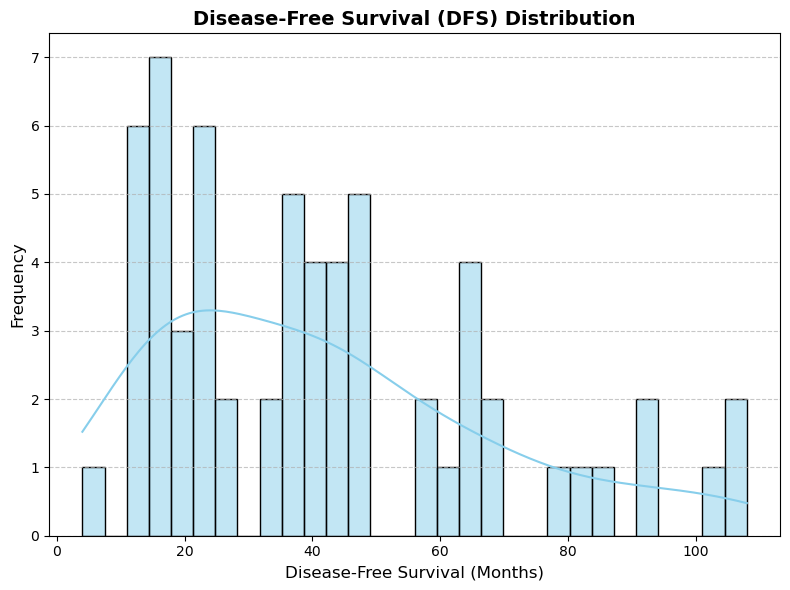

In [10]:
# Plot the histogram using Seaborn for better aesthetics
plt.figure(figsize=(8, 6))
sns.histplot(
    data=cancer_df, 
    x='DFS (in months)', 
    bins=30, 
    kde=True,
    color='skyblue', 
    edgecolor='black'
)

plt.title("Disease-Free Survival (DFS) Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Disease-Free Survival (Months)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

- **Distribution Shape**:
   - The distribution of DFS (in months) is **right-skewed**, with most patients having shorter DFS durations.
   - A small number of patients have DFS extending to 100+ months.

- **Frequency Peaks**:
   - There are noticeable peaks around 10–20 months and 50–60 months, indicating clusters of patients with shorter and moderate DFS durations.

- **Spread**:
   - DFS durations range from **4 months (minimum)** to **108 months (maximum)**.
   - Most values are concentrated below 60 months, as indicated by the density curve.

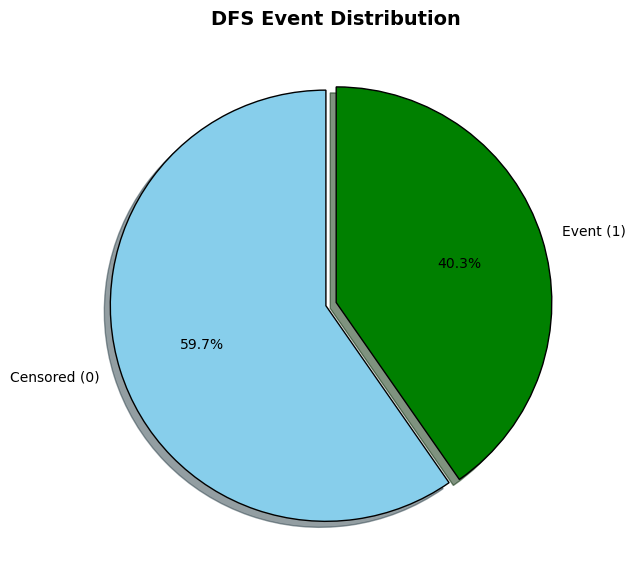

In [11]:
# Count the values for DFS event
dfs_event_counts = cancer_df['DFS event'].value_counts()

fig, ax = plt.subplots(figsize=(7, 7))
colors = ['skyblue', 'green']
explode = [0.05, 0]

ax.pie(
    dfs_event_counts,
    labels=['Censored (0)', 'Event (1)'],
    autopct='%1.1f%%',
    startangle=90,
    explode=explode,
    colors=colors,
    shadow=True,
    wedgeprops={'edgecolor': 'black'}
)

ax.set_title("DFS Event Distribution", fontsize=14, fontweight='bold')

plt.show()

- **Distribution of Events**:
   - **Censored (0)**: Represents **59.7%** of the data, indicating these patients did not experience a DFS event (e.g., recurrence or death) during the observation period.
   - **Event (1)**: Represents **40.3%** of the data, indicating these patients experienced a DFS event.

- **Balance**:
   - The dataset shows a relatively balanced distribution between censored and event occurrences, with a slight majority in the censored group.

- **Implications for Analysis**:
   - This balanced proportion provides a robust dataset for survival analysis, as both censored and event groups are adequately represented.

## **Preprocessing**


| **Feature Type**         | **Columns**                                                                 | **Transformation**                                  | **Details**                                                                                   |
|---------------------------|-----------------------------------------------------------------------------|----------------------------------------------------|-----------------------------------------------------------------------------------------------|
| **Passthrough Features**  | `DFS (in months)`, `DFS event`, `Age (in years)`, `Adj_Radio`, `Adj_Chem`   | Passthrough                                        | These features are kept as is, without any transformations.                                   |
| **Categorical Features**  | `Location`                                                                 | OneHotEncoder                                      | Encodes categories into one-hot vectors. Handles unknown categories using `handle_unknown="ignore"`. |
| **Binary Features**       | `Gender`                                                                   | OneHotEncoder with `drop="if_binary"`              | Encodes binary features into one-hot vectors and drops one level to avoid redundancy.         |
| **Ordinal Features**      | `Dukes Stage`                                                              | OrdinalEncoder                                     | Encodes the ordered categories (`['A', 'B', 'C', 'D']`) into integers.                        |
| **Numeric Features**      | `PC1`, `PC2`, ..., `PCn` (from Principal Component Analysis)                | StandardScaler                                     | Standardizes features to have a mean of 0 and a standard deviation of 1.                      |

In [12]:
# Define feature groups
passthrough_features = ['DFS (in months)', 'DFS event', 'Age (in years)', 'Adj_Radio', 'Adj_Chem']
categorical_features = ['Location']
binary_features = ['Gender']
ordinary_features = ['Dukes Stage']
numeric_features = [f'PC{i+1}' for i in range(gene_data_pca.shape[1])]

preprocessor = make_column_transformer(
    (
        "passthrough",
        passthrough_features,
    ),
    (
        OneHotEncoder(handle_unknown="ignore"),
        categorical_features,
    ),
    (
        OneHotEncoder(drop="if_binary", handle_unknown="ignore"),
        binary_features,
    ),
    (
        OrdinalEncoder(categories=[['A', 'B', 'C', 'D']]),
        ordinary_features,
    ),
    (
        StandardScaler(),
        numeric_features,
    )
)

In [13]:
preprocessor.fit(cancer_df)

ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                 ['DFS (in months)', 'DFS event',
                                  'Age (in years)', 'Adj_Radio', 'Adj_Chem']),
                                ('onehotencoder-1',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Location']),
                                ('onehotencoder-2',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore'),
                                 ['Gender']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['A', 'B', 'C',
                                                             'D']]),
                                 ['Dukes Stage']),
                                ('standardscaler', StandardScaler(),
                                 ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6',
                                  'PC7', 'PC8', 'PC9', 'PC10'])])

In [14]:
new_columns = (
    passthrough_features
    + preprocessor.named_transformers_["onehotencoder-1"]
    .get_feature_names_out(categorical_features)
    .tolist()
    + preprocessor.named_transformers_["onehotencoder-2"]
    .get_feature_names_out(binary_features)
    .tolist()
    + preprocessor.named_transformers_["ordinalencoder"]
    .get_feature_names_out(ordinary_features)
    .tolist()
    + numeric_features
)

In [15]:
cancer_df_surv = pd.DataFrame(
    preprocessor.transform(cancer_df), index=cancer_df.index, columns=new_columns
)

In [16]:
display(cancer_df_surv.head())

,DFS (in months),DFS event,Age (in years),Adj_Radio,Adj_Chem,Location_Colon,Location_Left,Location_Rectum,Location_Right,Gender_Male,...,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,108.0,0.0,62.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.690371,-0.474292,0.105510,1.029545,1.554643,0.700039,0.291275,-0.480326,-0.367550,0.175293
1,40.0,1.0,77.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.665861,1.091053,-1.810395,-2.216717,-0.398797,1.293620,0.710828,1.273473,0.417849,1.620073
2,49.0,0.0,66.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.972914,-0.611976,-0.288582,0.450546,0.078611,0.154671,-0.304219,0.886651,-2.502641,0.852376
3,45.0,0.0,72.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,2.033161,-0.661475,0.031354,0.237474,-0.086228,-0.423905,-0.435577,1.715649,0.278953,-1.615547
4,40.0,0.0,75.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.118596,1.097989,0.853899,-0.444289,0.760363,0.017561,1.353270,0.819576,0.115883,0.048644


## **Kaplan-Meier survival curve**

In [17]:
kmf = lifelines.KaplanMeierFitter()
kmf.fit(cancer_df_surv["DFS (in months)"], cancer_df_surv["DFS event"])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 62 total observations, 25 right-censored observations>

### **Survival curve**

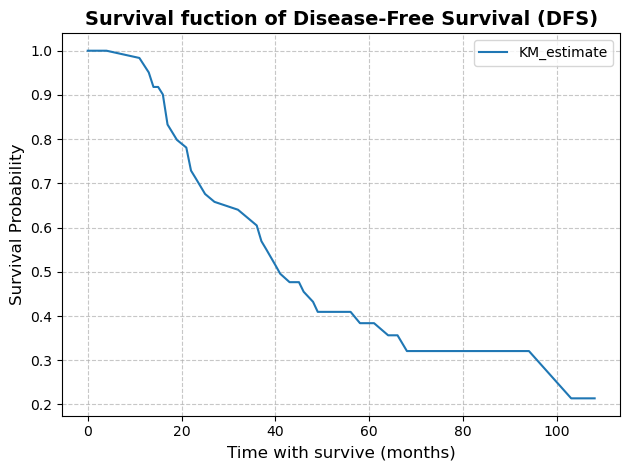

In [18]:
kmf.survival_function_.plot();
plt.title("Survival fuction of Disease-Free Survival (DFS)", fontsize=14, fontweight='bold')
plt.xlabel("Time with survive (months)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- The Kaplan-Meier curve shows a **gradual decline** in survival probability, with the steepest drop in the first **40 months**.
- The **median DFS** is approximately **40 months**, indicating that **50% of patients** experience disease recurrence or death by this time.
- A small subset of patients maintains disease-free survival for **100+ months**, with survival probability stabilizing around **20%**.

### **Error bars**

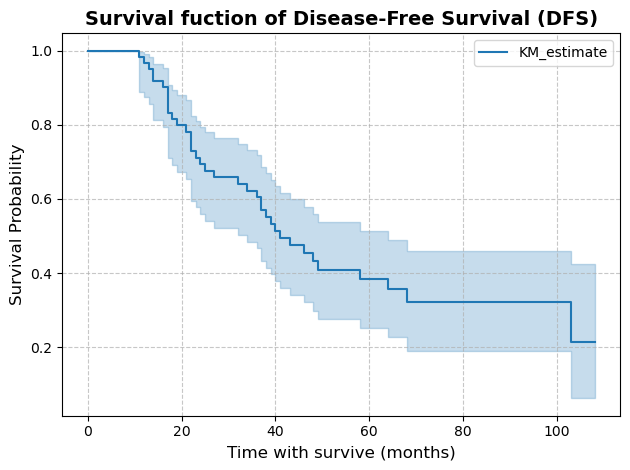

In [19]:
kmf.plot_survival_function()
plt.title("Survival fuction of Disease-Free Survival (DFS)", fontsize=14, fontweight='bold')
plt.xlabel("Time with survive (months)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- At earlier time points (e.g., **0–40 months**), confidence intervals (shaded regions) are narrower, reflecting higher certainty due to a larger number of patients and observations.
- As survival time increases (e.g., **beyond 60 months**), fewer patients remain under observation, resulting in wider intervals and greater uncertainty in survival probability estimates.

## **Cox proportional hazards model**

In [20]:
cph = lifelines.CoxPHFitter(penalizer=0.1)
cph.fit(cancer_df_surv, duration_col="DFS (in months)", event_col="DFS event")

<lifelines.CoxPHFitter: fitted with 62 total observations, 25 right-censored observations>

<Axes: xlabel='log(HR) (95% CI)'>

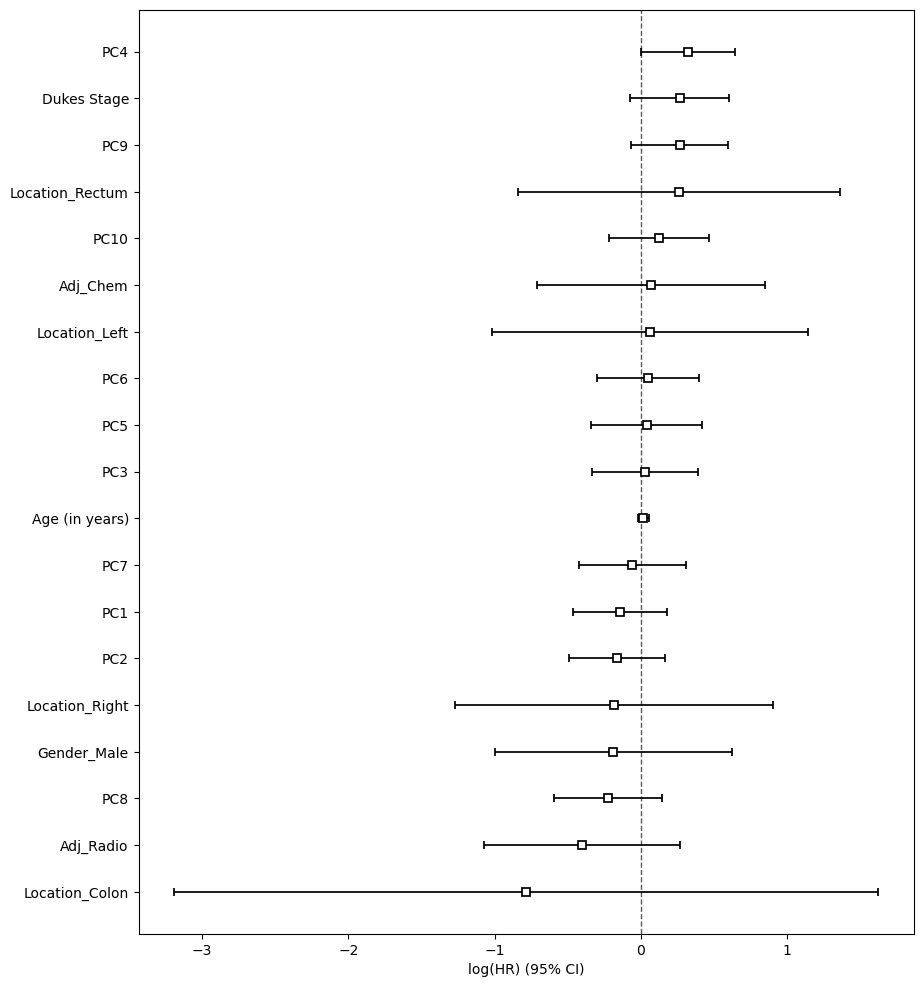

In [21]:
plt.figure(figsize=(10, 12))
cph.plot()

- **Significant Predictors**:
   - **Dukes Stage**: Positive coefficient with a narrow CI that does not cross 0 too much, indicating a significant increase in hazard (increase the risk of recurrence or death).
   - **Adj_Radio**: Narrow CI that does not cross 0 too much, suggesting a significant protective effect in reducing the hazard (reduce the risk of recurrence or death).
   - Many **PC** which represnet specifc gene types have either positive or negative coefficients are significant which suggests that genes are significant predictors.

- **Non-Significant Predictors**:
   - Predictors like **Gender_Male**, **Location_Colon**, and **PC9** have confidence intervals that cross 0, indicating no statistically significant impact on hazard.

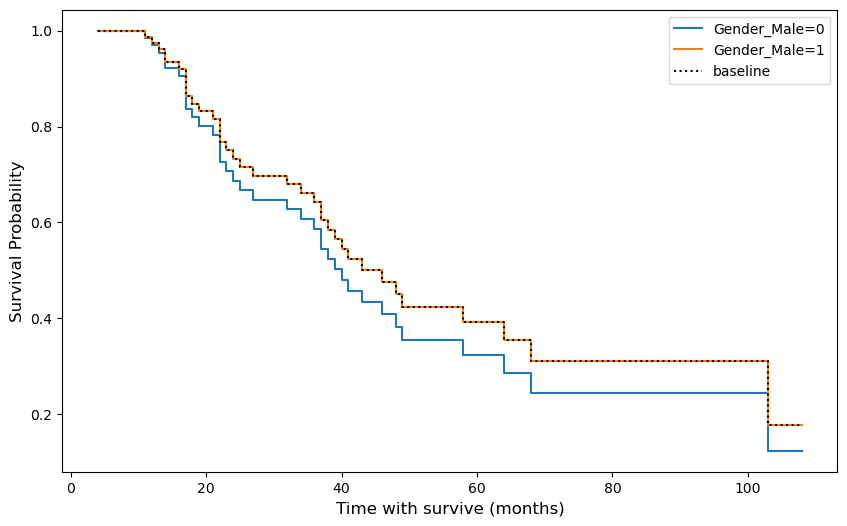

In [22]:
cph.plot_partial_effects_on_outcome("Gender_Male", [0, 1])
plt.xlabel("Time with survive (months)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.gcf().set_size_inches(10, 6)

- **Gender Differences in Survival**:
   - The survival probability for **males** is slightly higher than for **females** across most of the observation period.
   - This indicates that males may have a marginally better survival rate in this dataset.

- **No Significant Divergence**:
   - The survival curves for both genders follow a similar trend, with no substantial divergence observed, suggesting gender may not have a strong impact on survival.


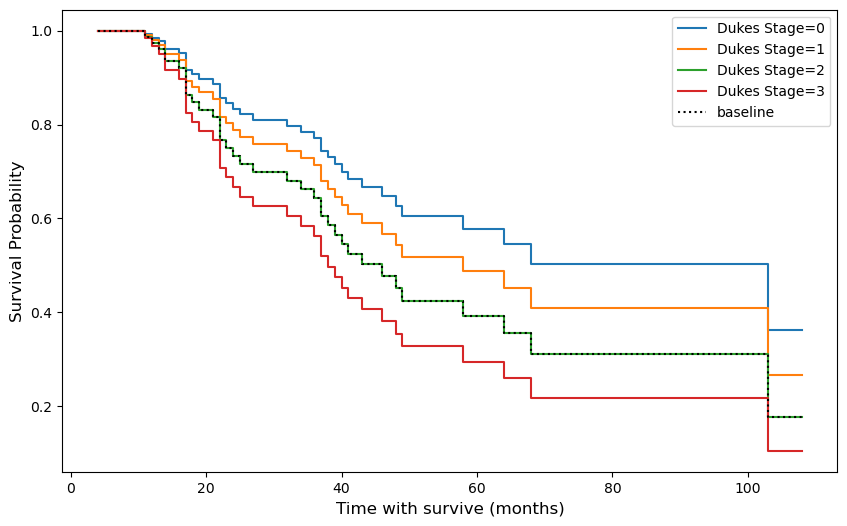

In [23]:
cph.plot_partial_effects_on_outcome("Dukes Stage", [0, 1, 2, 3])
plt.xlabel("Time with survive (months)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.gcf().set_size_inches(10, 6)

- **Trend Over Time**:
   - Survival probability decreases for all stages over time, but the rate of decline is faster for higher stages (e.g., Dukes Stage 2 and 3).
   - The survival curves are well-separated by stage, reflecting a clear impact of disease severity on survival outcomes.

- **Long-Term Survival**:
   - **Dukes Stage 0 and 1** stabilize at higher survival probabilities (~60-70%) after 80 months.
   - **Dukes Stage 3** has the lowest long-term survival (~20%).

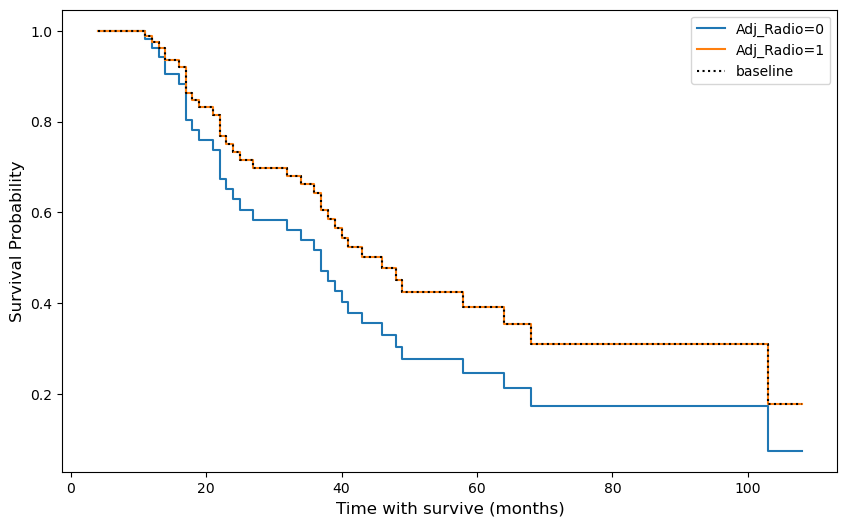

In [24]:
cph.plot_partial_effects_on_outcome('Adj_Radio', [0, 1])
plt.xlabel("Time with survive (months)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.gcf().set_size_inches(10, 6)

- **Survival Probability with Radiotherapy**:
   - Patients who **received radiotherapy** have consistently higher survival probabilities compared to those who **did not receive radiotherapy**.

- **Long-Term Survival**:
   - Patients who **received radiotherapy** stabilize at a higher survival probability (~40%) after 80 months, while those w who **did not receive radiotherapy** have a survival probability below 20%, indicating that radiotherapy improves disease-free survival (**DFS**) time.

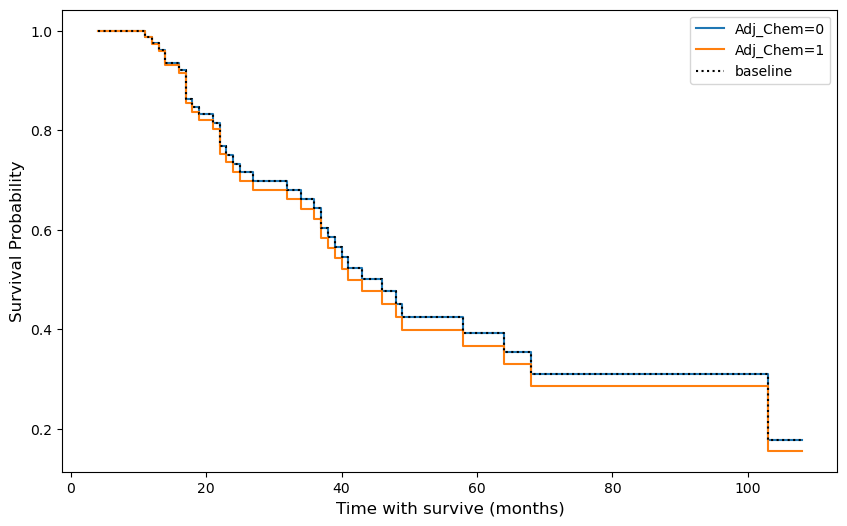

In [25]:
cph.plot_partial_effects_on_outcome('Adj_Chem', [0, 1])
plt.xlabel("Time with survive (months)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.gcf().set_size_inches(10, 6)

- **Survival Probability with Chemotherapy**:
   - Patients who **received chemotherapy** have slightly lower survival probabilities compared to those who **did not receive chemotherapy**.

- **Long-Term Survival**:
   - Both groups stabilize at similar survival probabilities (~20%) after 100 months, indicating minimal difference in long-term survival outcomes, suggesting that chemotherapy does not significantly impact disease-free survival (**DFS**) time.